## **Diabetes Data Observation**

I found this Diabetes prediction dataset from Kaggle (https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset) <br>
My goal is to explore this dataset and find out the key factors of a person developing diabetes, finding insights and corelation between features with visualization and multiple testing

0. Importing Libraries

In [26]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from statsmodels.stats.proportion import proportions_ztest
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import ttest_ind, ttest_1samp, chi2_contingency, shapiro, probplot

<h3>1. Data Cleaning and Wrangling</h3>

1.1. Dataset loading

In [27]:
#Colab Link of this project: https://colab.research.google.com/drive/1qzqLE_6P0TnFybPaOhSjU71XJ1IDXwTK?usp=sharing


url = 'https://raw.githubusercontent.com/Suthfan/diabetes-prediction/refs/heads/main/diabetes_prediction_dataset.csv'
df = pd.read_csv(url)
print("\nShape:", df.shape)
print(df.head())


Shape: (2000, 9)
   gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  0.08           0.0            0.0         No Info  14.43   
1  Female  0.16           0.0            0.0         No Info  12.15   
2    Male  0.16           0.0            0.0         No Info  14.35   
3    Male  0.16           0.0            0.0         No Info  11.16   
4  Female  0.56           0.0            0.0         No Info  16.85   

   HbA1c_level  blood_glucose_level  diabetes  
0          6.5                160.0         0  
1          6.6                100.0         0  
2          6.5                126.0         0  
3          5.8                 85.0         0  
4          5.0                140.0         0  


1.2. Handaling missing values

As there is mostly 1 value missing from each row, we can just use mode/ median for them. Or just drop them

In [28]:
print("\nMissing values:\n", df.isna().sum())
df['gender'] = df['gender'].fillna(df['gender'].mode()[0]) # most frequent gender to na values
df['bmi'] = df['bmi'].fillna(df['bmi'].median()) # median of BMI to na values
df['smoking_history'] = df['smoking_history'].fillna('No Info') # No Info to na values
df.dropna(inplace=True)
df.drop_duplicates(inplace=True) # Removing dupli
print("Total null values:",df.isnull().sum().sum())
print("\nShape:", df.shape)


Missing values:
 gender                 1
age                    1
hypertension           1
heart_disease          1
smoking_history        3
bmi                    4
HbA1c_level            1
blood_glucose_level    1
diabetes               0
dtype: int64
Total null values: 0

Shape: (1995, 9)


1.3. Checking all unique value of each columns, so we can check if the column is categorical or numerical

In [29]:
print(df.dtypes)
for col in df.columns:
    print(f"Column: {col}")
    print(df[col].unique())
    print()

gender                  object
age                    float64
hypertension           float64
heart_disease          float64
smoking_history         object
bmi                    float64
HbA1c_level            float64
blood_glucose_level    float64
diabetes                 int64
dtype: object
Column: gender
['Female' 'Male']

Column: age
[ 0.08  0.16  0.56  0.64  0.72  0.8   0.88  1.16  1.24  1.32  1.64  1.88
  2.    3.    4.    5.    6.    7.    8.    9.   10.   11.   12.   13.
 14.   15.   16.   17.   18.   19.   20.   21.   22.   23.   24.   25.
 26.   27.   28.   29.   30.   31.   32.   33.   34.   35.   36.   37.
 38.   39.   40.   41.   42.   43.   44.   45.   46.   47.   48.   49.
 50.   51.   52.   53.   54.   55.   56.   57.   58.   59.   60.   61.
 62.   63.   64.   65.   66.   67.   68.   69.   70.   71.   72.   73.
 74.   75.   76.   77.   78.   79.   80.  ]

Column: hypertension
[0. 1.]

Column: heart_disease
[0. 1.]

Column: smoking_history
['No Info' 'never' 'not current'

Here, <br>
Column: gender, hypertension, heart_disease, smoking_history, diabetes are categorical <br>
Column: age, bmi, HbA1c_level, blood_glucose_level are numeric <br>
So, we need to change hypertension, heart_disease to categorical and rest of them to numerical

1.4. Managing category and numeric values

In [30]:
categorical_columns = ['hypertension', 'heart_disease']
for col in categorical_columns:
    if col in df.columns:
        df[col] = df[col].astype('category')

numeric_columns = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']
for col in numeric_columns:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col])

print("Data Types\n",df.dtypes)

Data Types
 gender                   object
age                     float64
hypertension           category
heart_disease          category
smoking_history          object
bmi                     float64
HbA1c_level             float64
blood_glucose_level     float64
diabetes                  int64
dtype: object


1.5. To remove outliner we need to make a function and pass the numeric columns to them

In [31]:
def remove_outliers_iqr(df, cols):
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

1.6. First visualize them with seaborn library

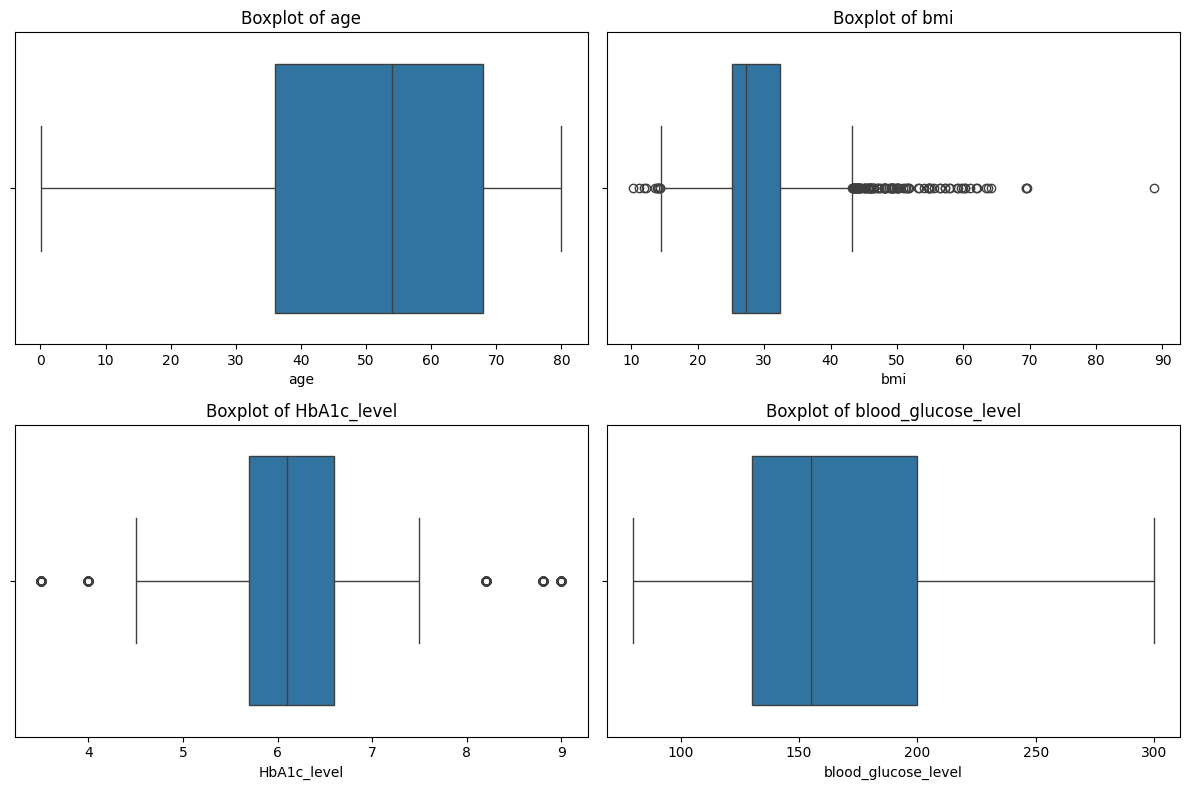

In [32]:


fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # 2 rows, 2 columns
axes = axes.flatten()
for i, col in enumerate(numeric_columns):
    sns.boxplot(data=df, x=col, ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()



1.7. We can see from the plots there are lots of outliners

In [33]:
df_clean = remove_outliers_iqr(df, numeric_columns)
print("\nShape:", df_clean.shape)
print("\nRemoved outlined rows:", df.shape[0]-df_clean.shape[0])


Shape: (1488, 9)

Removed outlined rows: 507


<h3>2. Visualizations</h3>

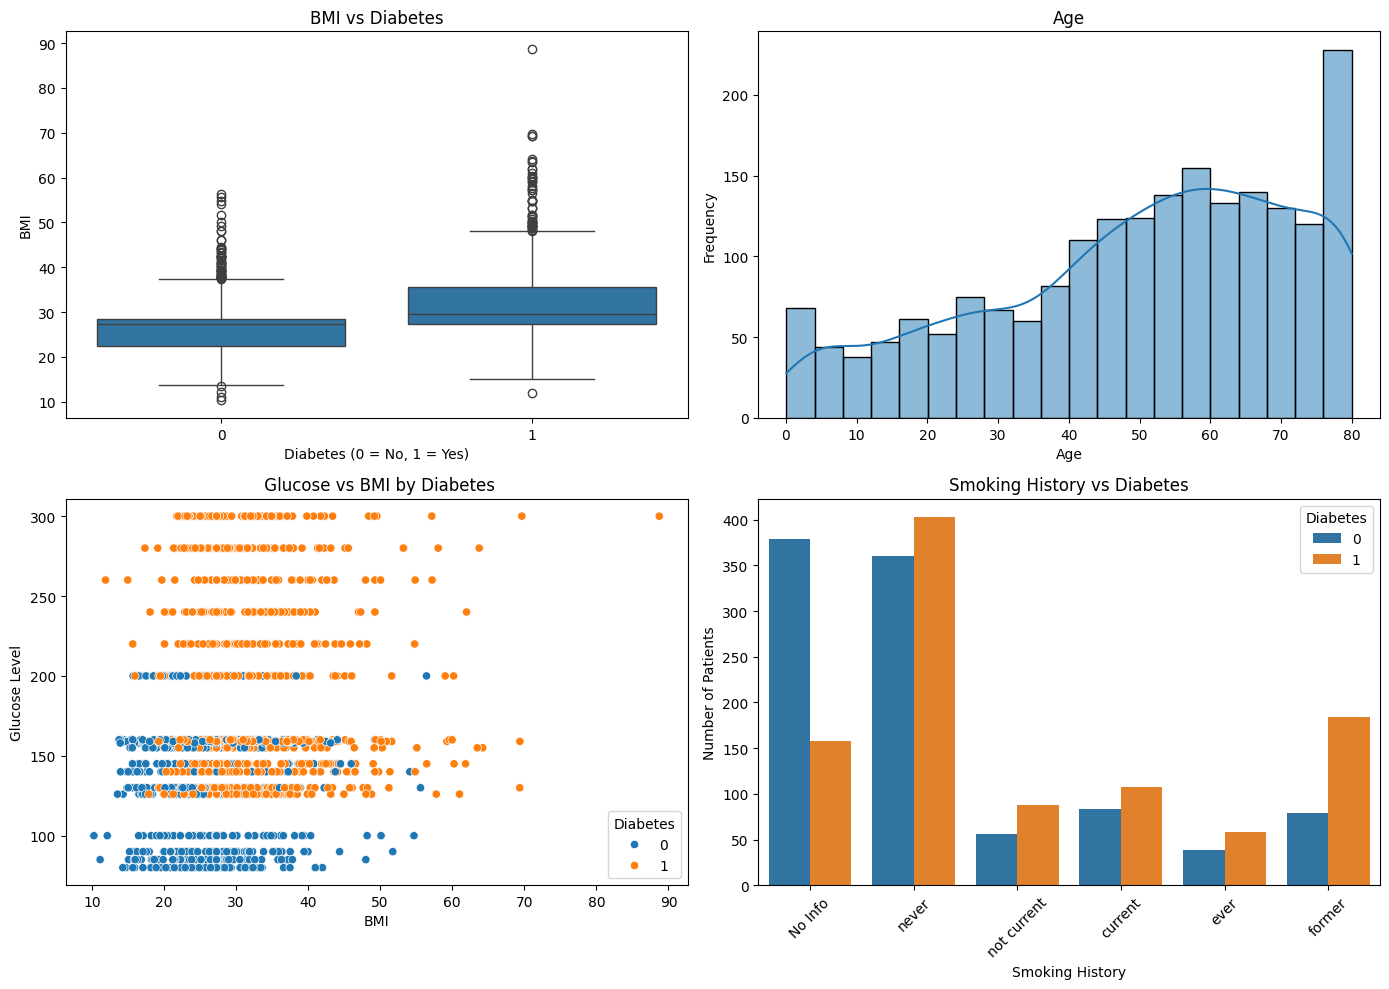

In [34]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

sns.boxplot(data=df, x='diabetes', y='bmi', ax=axes[0, 0])
axes[0, 0].set_title('BMI vs Diabetes')
axes[0, 0].set_xlabel('Diabetes (0 = No, 1 = Yes)')
axes[0, 0].set_ylabel('BMI')

sns.histplot(data=df, x='age', bins=20, kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Age')
axes[0, 1].set_xlabel('Age')
axes[0, 1].set_ylabel('Frequency')

sns.scatterplot(data=df, x='bmi', y='blood_glucose_level', hue='diabetes', ax=axes[1, 0])
axes[1, 0].set_title(' Glucose vs BMI by Diabetes')
axes[1, 0].set_xlabel('BMI')
axes[1, 0].set_ylabel('Glucose Level')
axes[1, 0].legend(title='Diabetes')

sns.countplot(data=df, x='smoking_history', hue='diabetes', ax=axes[1, 1])
axes[1, 1].set_title('Smoking History vs Diabetes')
axes[1, 1].set_xlabel('Smoking History')
axes[1, 1].set_ylabel('Number of Patients')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].legend(title='Diabetes')

# Adjust layout
plt.tight_layout()
plt.show()


2.1. BMI Distribution by Diabetes Status (Boxplot) <br>
Observation: Those who have diabetes, most of their time they have higher BMI.<br>
Insight: High BMI is positively correlated with diabetes. <br>

2.2. Age Distribution (Histogram)<br>
Observation: Most of the people are aged 40 to 80, peak ages are around 50 to 60 and 70 to 80.<br>
Insight: Age distribution is right-skewed. Older populations dominate the dataset.<br>

2.3. Blood Glucose vs. BMI by Diabetes Status (Scatter Plot)<br>
Observation: We can see diabetic individuals (orange dots) generally have higher blood glucose levels, most of them are over 120 to 300. But most non-diabetic people (blue dots) have glucose levels  below 160. Higher BMI also corresponds with higher glucose levels in diabetics.<br>
Insight: There is a strong relationship between high glucose levels and diabetes.<br>

2.4. Smoking History vs. Diabetes Status (Bottom-Right Bar Plot)<br>
Observation: "No Info" and "never" category have a huge number of non-diabetics. Though, diabetic patients are more common in "former", "current", and "not current" categories.<br>
Insight: While "No Info" dominates, "former" and "current" smokers have higher proportions of diabetics, suggesting a potential association between smoking and diabetes risk.<br>

<h3>3. Proportions (probabilities) based on the observed data

<h4>3.1. AND Logic</h4>
Q: What is the probability that a person has both hypertension and diabetes?

In [35]:
hyperbetes = len(df[(df['hypertension'] == 1) & (df['diabetes'] == 1)]) / len(df)
print(f"Probability of (hypertension AND diabetes) = {hyperbetes:.4f}")

Probability of (hypertension AND diabetes) = 0.1158


Around 11.64% of people have both hypertension and diabetes. These two conditions often coexist when someone have a bad lifestyle

<h4>3.2. OR Logic</h4>
Q: Q: What is the probability that a person has hypertension OR heart disease?

In [36]:
hyperbetes = len(df[(df['hypertension'] == 1) | (df['heart_disease'] == 1)]) / len(df)
print(f"P(hypertension OR heart_disease) = {hyperbetes:.4f}")

P(hypertension OR heart_disease) = 0.2080


20.92% people has either hypertension or heart disease. Almost 1 in 5 people suffers from cardiovascular risk.

<h4>3.3. Conditional</h4>
Q: What is the probability that a person is diabetic given they are a smoker?

In [37]:
smoker = df[df['smoking_history'] != 'never']  # or any specific category like 'current'
p_diabetes_given_smoker = len(smoker[smoker['diabetes'] == 1]) / len(smoker)
print(f"P(diabetes | smoker) = {p_diabetes_given_smoker:.4f}")

P(diabetes | smoker) = 0.4838


Almost 49% of smokers have diabetes. This is a very high conditional probability, so there can be a strong link between smoking and diabetes.

<h4>3.4. Conditional</h4>
Q: What is the probability that a person has heart disease given they have hypertension?

In [38]:
hypertensive = df[df['hypertension'] == 1]
p_hd_given_ht = len(hypertensive[hypertensive['heart_disease'] == 1]) / len(hypertensive)
print(f"P(heart_disease | hypertension) = {p_hd_given_ht:.4f}")


P(heart_disease | hypertension) = 0.1419


14.19% people with hypertension also have heart disease. This highlights that hypertension can lead to or coexist with heart disease.

<h3>4. Probabilities based on the normal distribution model

4.1. We will check histogram, Shapiro-Wilk Test, QQ to see if the numeric values are normally distributed or not

Normality test for age


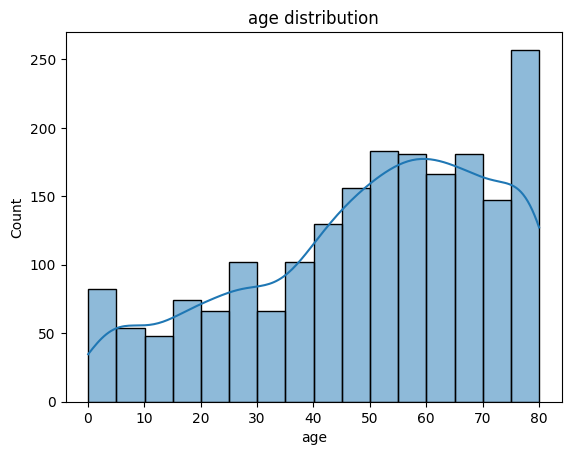

Shapiro-Wilk Test: W = 0.9441, p value = 0.0000
Not normal


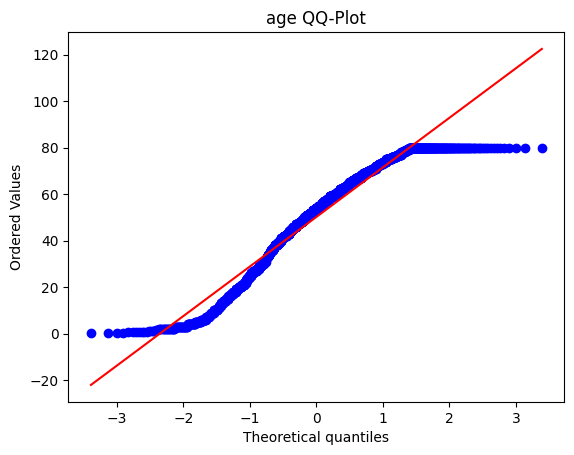

Normality test for bmi


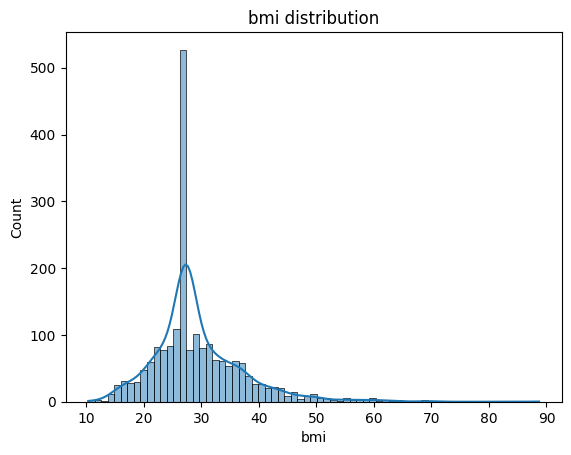

Shapiro-Wilk Test: W = 0.9053, p value = 0.0000
Not normal


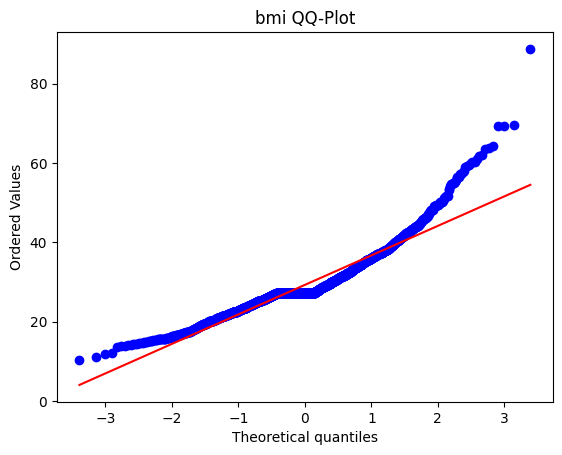

Normality test for HbA1c_level


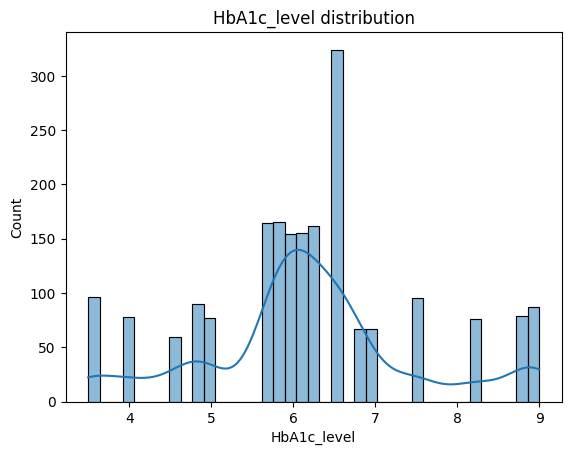

Shapiro-Wilk Test: W = 0.9450, p value = 0.0000
Not normal


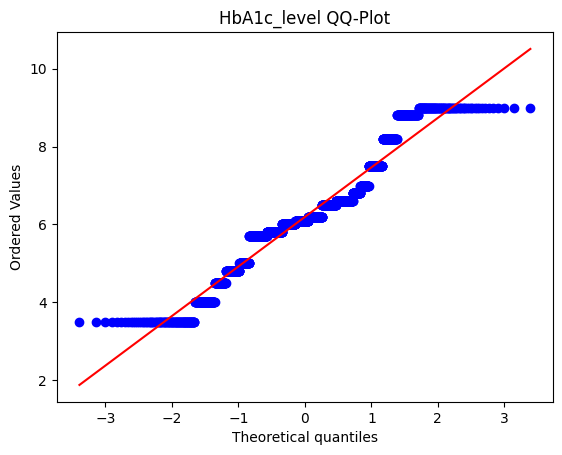

Normality test for blood_glucose_level


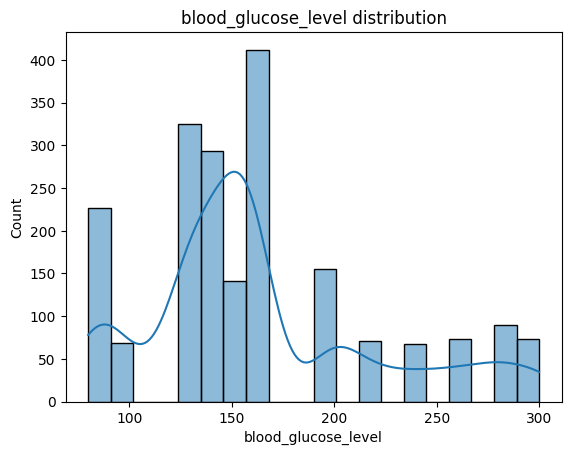

Shapiro-Wilk Test: W = 0.8998, p value = 0.0000
Not normal


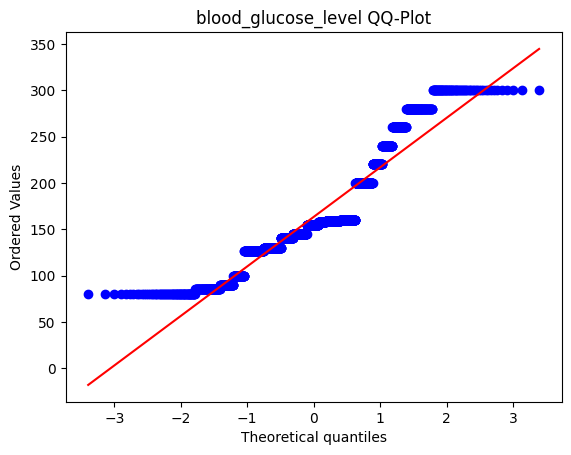

In [39]:


for col in numeric_columns:
    print(f"Normality test for {col}")
    sns.histplot(df[col], kde=True)
    plt.title(f'{col} distribution')
    plt.show()

    stat, p = shapiro(df[col])
    print(f"Shapiro-Wilk Test: W = {stat:.4f}, p value = {p:.4f}")
    if p > 0.05:
        print("Normal")
    else:
        print("Not normal")

    probplot(df[col], dist="norm", plot=plt)
    plt.title(f'{col} QQ-Plot')
    plt.show()


We can see none of these columns follow a normal distribution. So we need to use Central Limit Theorem. Because we have enough sample data to do normal distribution questions based on sampling means, not individual data points

4.2. Question 1 – One sample <br>
Q: If we select a random person, what will be the probability of having blood glucose level above 180?

we used the error function. It is also called Gauss error function

In [40]:

def normal_cdf(x, mu=0, sigma=1):
    z = (x - mu) / (sigma * math.sqrt(2))
    return 0.5 * (1 + math.erf(z))

mu = df['blood_glucose_level'].mean()
sigma = df['blood_glucose_level'].std()
x = 180

p = 1 - normal_cdf(x, mu, sigma)
print(p)

0.38326828013641034


That means 38% probability to get a person with above 180 glucose level

4.3. Question 2 – Sample Mean <br>
Q: If we randomly select 50 people, what will be the probability of their avarage blood glucose level is above 150?

In [41]:
n = 50
x = 150

sigma_sample = sigma / math.sqrt(n)
p2 = 1 - normal_cdf(x, mu, sigma_sample)

print(p2)


0.9523766918793968


That means if we randomly select 50 people, there will be 95% chance they will be above 150 in glucose level

4.4. Question 3 – Probability Interval for Mean <br>
Q: Suppose we pick sample mean of 100 for blood glucose, what is the probabily they will be between 130 and 150?

In [42]:
x_low = 130
x_high = 150

p3 = normal_cdf(x_high, mu, sigma_sample) - normal_cdf(x_low, mu, sigma_sample)

print(p3)

0.047608746715550265


Only 4% chance there will be 130 to 150 glucose level in 100 people mean

<h3>5. Confidence Intervals

5.1. We will use the t-distribution when the population standard deviation (σ) is unknown, which is common for sample data

In [60]:
sample = df['blood_glucose_level']
n = len(sample)
mean = sample.mean()
std = sample.std(ddof=1)
confidence = 0.95

t_critical = stats.t.ppf((1 + confidence) / 2, df=n-1)
margin_error = t_critical * (std / np.sqrt(n))

ci_lower = mean - margin_error
ci_upper = mean + margin_error

print(f"95% Confidence Interval for mean blood glucose: ({ci_lower:.2f}, {ci_upper:.2f})")


95% Confidence Interval for mean blood glucose: (160.81, 165.76)


5.2. We can say with 95% confidence that the average blood glucose level is between 160.81  and 165.76

In [61]:
blood_glucose = df['blood_glucose_level']
sample_std = np.std(blood_glucose)
print(f"Sample standard deviation (s): {sample_std:.2f}")

Sample standard deviation (s): 56.29


In [62]:
z_critical = stats.norm.ppf((1 + confidence) / 2)
margin_error = z_critical * (sample_std / np.sqrt(n))
ci_lower = mean - margin_error
ci_upper = mean + margin_error
print(f"95% CI (known σ=40) for mean blood glucose: ({ci_lower:.2f}, {ci_upper:.2f})")

95% CI (known σ=40) for mean blood glucose: (160.81, 165.75)


5.3. we can say that the true mean blood glucose level is between 160.81 and 165.75

In [63]:
diabetes = df['diabetes']
p_hat = diabetes.mean()
n = len(diabetes)
z_critical = stats.norm.ppf(0.975)

margin_error = z_critical * np.sqrt((p_hat * (1 - p_hat)) / n)

ci_lower = p_hat - margin_error
ci_upper = p_hat + margin_error

print(f"95% CI for proportion with diabetes: ({ci_lower:.4f}, {ci_upper:.4f})")

95% CI for proportion with diabetes: (0.4788, 0.5227)


5.4. We are 95% confident that between 47.88% and 52.27% of the people have diabetes.This is a very high rate. Almost half of the population is estimated to be diabetic, that is higher than most general populations

<h3>6. Hypothesis testing

<h4>6.1. Test 1: One-Sample t-Test

Checking if the most of the people are in the risk of diabetes acording to avarage glucose level

Is the average person in this dataset at risk of diabetes based on glucose? <br>
If x = avg glucose level <br>
Hypothese 0: x = average blood glucose level <br>
Hypothese 1: x > average blood glucose level

In [64]:

diabetics = df[df['diabetes'] == 1]['blood_glucose_level']
mean = df['blood_glucose_level'].mean()
t, p = ttest_1samp(diabetics, popmean=mean)
if t > 0:
    p /= 2
else:
    p = 1 - (p / 2)

print(f"Mean of glucose : {mean:.2f}")
print(f"t = {t:.4f}, p = {p:.4f}")


Mean of glucose : 163.28
t = 15.9764, p = 0.0000


This means that the average blood glucose level among diabetic patients is significantly greater than the mean

<h4>6.2. Test 2: Two-Sample t-Test

Do people with and without diabetes have different HbA1c levels?

x1 = HbA1c level for diabetics and x2 = HbA1c level for non diabetics <br>
Hypothese 0: x1 = x2 <br>
Hypothese 1: x1 != x2

In [65]:
group1 = df[df['diabetes'] == 1]['HbA1c_level']
group2 = df[df['diabetes'] == 0]['HbA1c_level']

t, p = ttest_ind(group1, group2, equal_var=False)

print(f"Mean HbA1c for diabetics: {group1.mean():.2f}")
print(f"Mean HbA1c for non diabetics: {group2.mean():.2f}")
print(f"t = {t:.4f}, p = {p:.4f}")


Mean HbA1c for diabetics: 6.99
Mean HbA1c for non diabetics: 5.40
t = 34.0836, p = 0.0000


We can see strong difference of HbA1c levels between diabetic and non-diabetic individuals. This also means it will help to classify diabetes from HbA1c

<h4>6.3. Test 3: Proportion Test

Is the proportion of diabetics in the population greater than 40%?

p = sample proportion of individuals with diabetes = 1 <br>
Hypothese 0: p = 0.40 <br>
Hypothese 1: p > 0.40

In [66]:


sum_d = df['diabetes'].sum()
n = len(df)

z, p = proportions_ztest(sum_d, n, value=0.40, alternative='larger')

prop = sum_d / n
print(f"Proportion of diabetics: {prop:.4f}")
print(f"z = {z:.4f}, p = {p:.4f}")

Proportion of diabetics: 0.5008
z = 9.0003, p = 0.0000


This means the dataset was sampled from a higher risk population than the general one

<h3>7. Chi-square tests

<h4>7.1. Chi-Square Test of Independence

Hypothesis 0: Smoking history and diabetes status are not related. <br>
Hypothesis 1: There is a relationship between smoking history and diabetes status.

In [67]:


connection = pd.crosstab(df['smoking_history'], df['diabetes'])

chi, p, dof, exp = chi2_contingency(connection)

print("Contingency Table:\n", connection)
print(f"\nChi-square = {chi:.4f}, p-value = {p:.4f}, DoF = {dof}")


Contingency Table:
 diabetes           0    1
smoking_history          
No Info          379  158
current           83  108
ever              39   58
former            79  184
never            360  403
not current       56   88

Chi-square = 149.3959, p-value = 0.0000, DoF = 5


There is a good connection between smoking history and diabetes status. As p < 0.05, we reject the null hypothesis. Certain smoking categories like former or current smoker have a higher chance of diabetics than others.

<h4>7.2. Chi-Square Test of Homogeneity

Hypothesis 0: The gender distribution is the same to diabetics and non diabetics. <br>
Hypothesis 1: The gender distribution is not same between diabetics and non diabetics.

In [68]:
connection2 = pd.crosstab(df['diabetes'], df['gender'])

chi2_2, p2, dof2, expected2 = chi2_contingency(connection2)

print("\nContingency Table:\n", connection2)
print(f"\nChi-square = {chi2_2:.4f}, p-value = {p2:.4f}, DoF = {dof2}")



Contingency Table:
 gender    Female  Male
diabetes              
0            589   407
1            527   472

Chi-square = 7.9896, p-value = 0.0047, DoF = 1


There is a good difference in gender with and without diabetes. Since p < 0.05, we reject the null hypothesis. Males have a higher chance of having diabetes compared to females.

<h3>8. Additional Assessment / Freestyle

8.1. We can use heatmap to get corelation between all the features

Before making heatmap, we have to map categorical data into numeric. So we can calculate relation

In [69]:
df_mapped = df.copy()

df_mapped['gender'] = df_mapped['gender'].map({'Female': 0, 'Male': 1})
df_mapped['smoking_history'] = df_mapped['smoking_history'].map({
    'No Info': 0, 'never': 1, 'not current': 2,
    'current': 3, 'ever': 4, 'former': 5
})
df_mapped['diabetes'] = pd.to_numeric(df_mapped['diabetes'])

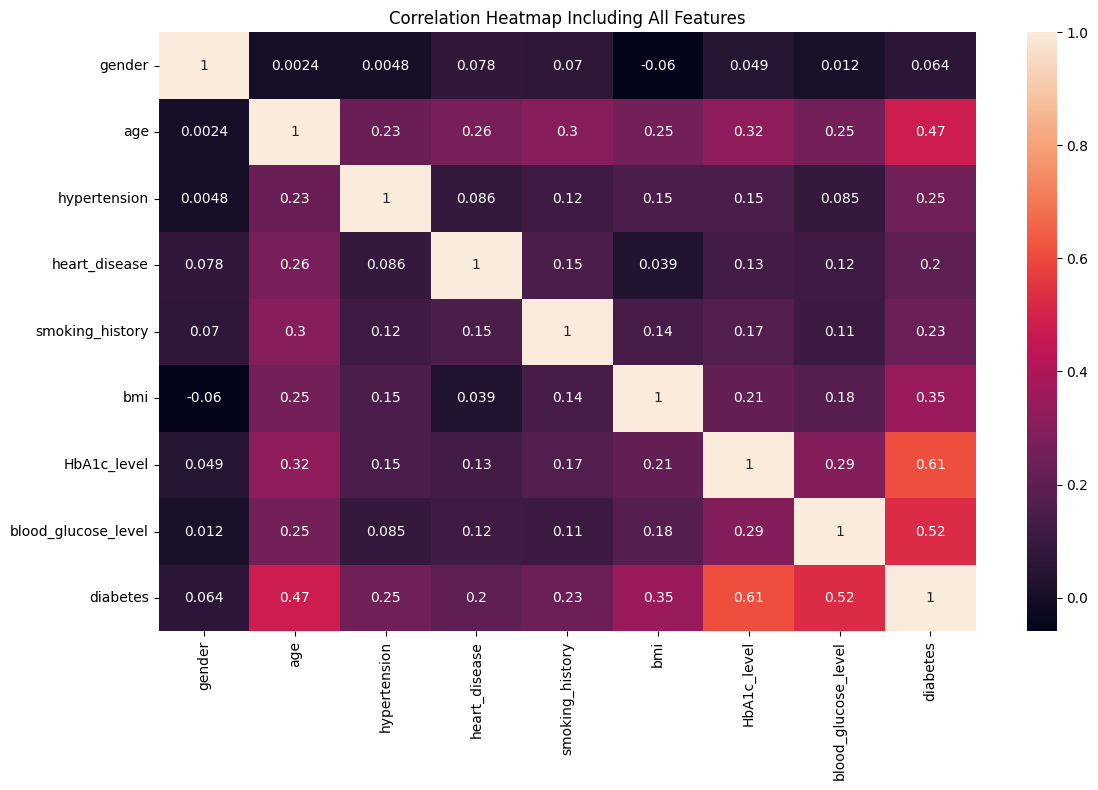

In [70]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_mapped.corr(), annot=True)
plt.title("Correlation Heatmap Including All Features")
plt.tight_layout()
plt.show()


8.2. Here we can see HbA1c level, blood glucose level, age, bmi, diabetes have higher corelation with diabetes. So we will pair plot them to get info about them

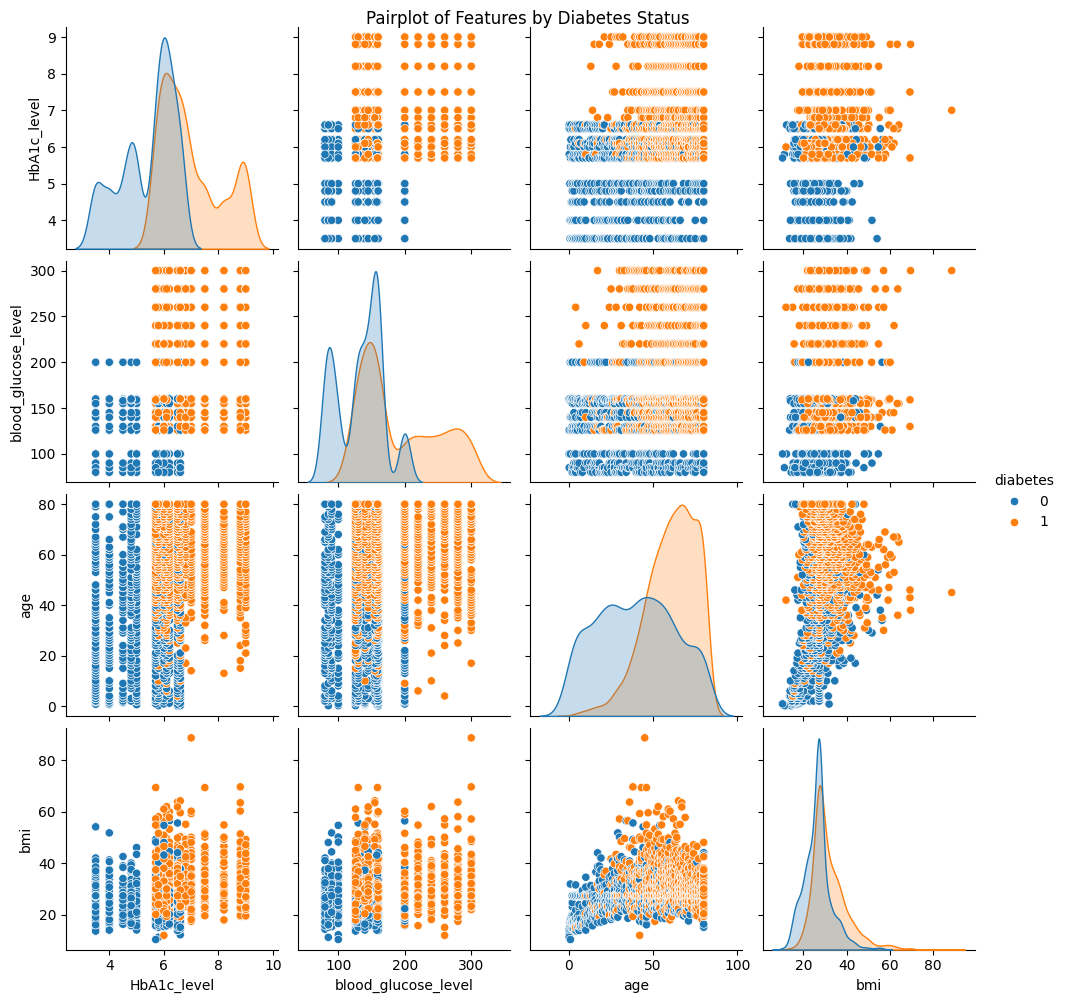

In [71]:
features = ['HbA1c_level', 'blood_glucose_level','age', 'bmi', 'diabetes']

sns.pairplot(df_mapped[features], hue='diabetes')
plt.suptitle("Pairplot of Features by Diabetes Status", y=1)
plt.show()

We can see a good relation between the features with diabetes. But we can't classify diabetes with a single feature, but combination of all of them will help to detect if someone have diabetes or not.